The purpose of this notebook is to perform descriptive statistics on the reports in our corpus and analyze the vocabulary and other features.

In [245]:
import os, sys
import pickle
import numpy as np
import scipy

import sqlite3 as sqlite

import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from sklearn.feature_selection import chi2, SelectKBest

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict, Counter
stop = set(stopwords.words('english'))

DATADIR = '../stats_data'
DB = os.path.join(DATADIR, 'Reference Standard', 'radiology_reports.sqlite')
os.path.exists(DB)

True

In [219]:
conn = sqlite.connect(DB)
df = pd.read_sql("SELECT * FROM training_notes;", conn)

conn.close()

In [220]:
df.head()

,rowid,name,text,referenceXML,doc_class,subject,HADM_ID,CHARTDATE
0,1,No_10792_131562_05-29-20,\n CT ABDOMEN W/CONTRAST; CT PELVIS W/CONTRAS...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,32,131562,05-29-20
1,2,No_11050_126785_11-03-33,\n CT CHEST W/CONTRAST; CT ABDOMEN W/CONTRAST...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,34,126785,11-03-33
2,3,No_11879_166554_06-22-37,\n CTA CHEST W&W/O C &RECONS; CT 100CC NON IO...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-22-37
3,4,No_11879_166554_06-23-37,\n CT ABDOMEN W/O CONTRAST; CT PELVIS W/O CON...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-23-37
4,5,No_11879_166554_07-02-37,\n CT CHEST W/O CONTRAST \n ~ Reason: r/o ste...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,07-02-37


# 1. Exploring Report Lengths and Vocabulary

To get a general sense of what our data looks like, I'll examine two features of the report: First, the length of the reports, and second, the number of unique words in each report. 

### 1a. Report Lengths

In [221]:
# Average lengths of reports
df["text"] = df.text.apply(lambda x: x.lower())
reports = df.text

In [222]:
len(reports)

545

In [223]:
rpt_lengths = [len(x) for x in reports]

In [236]:
# Define some helper functions
def display_statistics(arr, var_name):
    """
    Displays the mean and other descriptive statisistics 
    for an array of data.
    """
    print("Mean {}: {}".format(var_name, np.mean(arr)))
    print("Standard deviation {}: {}".format(var_name, np.std(arr)))
    print("Max {}: {}".format(var_name, np.max(arr)))
    print("Min {}: {}".format(var_name, np.min(arr)))
    
    
def plot_hist(arr, var_name):
    num_total = len(arr)
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arr, normed=1, alpha=0.9)
    
    # Add a line with the mean
    mean_value = np.mean(arr)
    ax.axvline(x=mean_value, c='orange')
    
    
    # Add a best fit line
    mu, sigma = scipy.stats.norm.fit(arr)

    y = mlab.normpdf(bins, mu, sigma)
    
    L = plt.plot(bins, y, 'r--', linewidth=2)
    
    
    ax.set_title("Distribution of {}".format(var_name))
    return fig, ax

def plot_boxplot(arr, var_name):
    fig, ax = plt.subplots()
    ax.boxplot(arr)
    ax.set_title("Distribution of {}".format(var_name))
    return fig, ax

def count_unique_words(text):
    """
    Counts the number of unique words in a text
    """
    return len(set(word_tokenize(text)))

In [238]:
display_statistics(rpt_lengths, "Report Length")

Mean Report Length: 3443.256880733945
Standard deviation Report Length: 1516.280203363879
Max Report Length: 8806
Min Report Length: 393


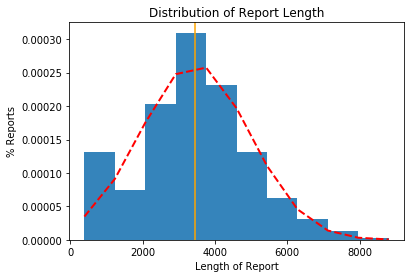

In [239]:
fig, ax =plot_hist(rpt_lengths, "Report Length")
ax.set_ylabel("% Reports")
_ = ax.set_xlabel("Length of Report")

Text(0,0.5,'Length of Report')

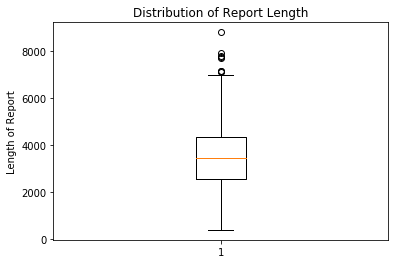

In [240]:
fig, ax = plot_boxplot(rpt_lengths, "Report Length")
ax.set_ylabel("Length of Report")

### 1.b Number of Unique Words in a Report

In [241]:
unique_word_counts = [count_unique_words(r) for r in reports]

In [242]:
display_statistics(unique_word_counts, "Unique Word Count")

Mean Unique Word Count: 236.81284403669724
Standard deviation Unique Word Count: 78.47597552189644
Max Unique Word Count: 477
Min Unique Word Count: 48


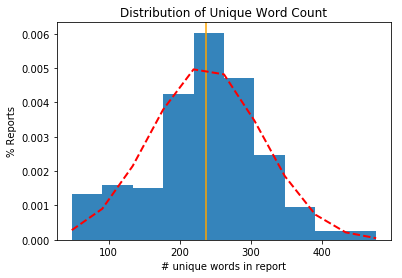

In [244]:
fig, ax = plot_hist(unique_word_counts, "Unique Word Count")
ax.set_xlabel("# unique words in report")
_ = ax.set_ylabel("% Reports")

# 2. Ranking the salience of words

Our task is determining whether or not a fluid collection is present based on the text. To do this, we'll examine the vocabulary and determine which words are most indicitive of a positive document.

We'll use two methods for this:
a. Conditional Probablity
We want to compute the probability of the class "Fluid collection - positive" given a particular word. This is calculated as:
# TODO: Change this to a Latex Formula
Freq(positive, word) / Freq(word)

b. Chi2 Test
We'll use a Chi2 test of statistical independence to determine how strongly a particular word is associated with the positive class.


### 2a. Conditional Probablity

In [255]:
# We'll consider unigrams and bigrams (one and two-word phrases)
ngram_reports = []
for text in df.text:
    tokens = []
    # Unigrams
    unigrams = [t for t in word_tokenize(text) if t not in stop]
    tokens += [(word, ) for word in unigrams]
    # Bigrams
    tokens += ngrams(unigrams, 2)
    # Trigrams
#     tokens += ngrams(unigrams, 3)


    ngram_reports.append(tokens)

In [256]:
# Create a dictionary that counts how many times a word occurs in either a positive or negative report
vocab = {}
for i, row in df.iterrows():
    
    grams = ngram_reports[i]
    c = 'negative' if row.doc_class == 0 else 'positive'
    for gram in grams:
        if gram not in vocab:
            vocab[gram] = {'positive': 0, 'negative': 0}
        vocab[gram][c] += 1

In [257]:
vocab

{('ct',): {'negative': 1319, 'positive': 1115},
 ('abdomen',): {'negative': 860, 'positive': 754},
 ('w/contrast',): {'negative': 218, 'positive': 219},
 (';',): {'negative': 358, 'positive': 297},
 ('pelvis',): {'negative': 787, 'positive': 767},
 ('~',): {'negative': 2998, 'positive': 2308},
 ('reason',): {'negative': 642, 'positive': 473},
 (':',): {'negative': 3754, 'positive': 2861},
 ('assess',): {'negative': 149, 'positive': 141},
 ('undrained',): {'negative': 8, 'positive': 11},
 ('collections',): {'negative': 68, 'positive': 197},
 ('w/po',): {'negative': 4, 'positive': 0},
 ('iv',): {'negative': 692, 'positive': 540},
 ('contrast',): {'negative': 1883, 'positive': 1555},
 ('admitting',): {'negative': 316, 'positive': 237},
 ('diagnosis',): {'negative': 330, 'positive': 244},
 ('bile',): {'negative': 41, 'positive': 36},
 ('duct',): {'negative': 36, 'positive': 53},
 ('injury',): {'negative': 26, 'positive': 46},
 ('optiray',): {'negative': 197, 'positive': 145},
 ('amt',): {'

In [258]:
cond_probs = {}
# Limit to words that occur at least 10 times
for gram, d in vocab.items():
    total_count = d['negative'] + d['positive']
    if total_count < 10:
        continue
    cond_probs[' '.join(gram)] = {"cond_prob": d["positive"]/total_count, "total_count": total_count}
    
cond_probs 

{'ct': {'cond_prob': 0.4580936729663106, 'total_count': 2434},
 'abdomen': {'cond_prob': 0.46716232961586124, 'total_count': 1614},
 'w/contrast': {'cond_prob': 0.5011441647597255, 'total_count': 437},
 ';': {'cond_prob': 0.4534351145038168, 'total_count': 655},
 'pelvis': {'cond_prob': 0.49356499356499356, 'total_count': 1554},
 '~': {'cond_prob': 0.4349792687523558, 'total_count': 5306},
 'reason': {'cond_prob': 0.4242152466367713, 'total_count': 1115},
 ':': {'cond_prob': 0.4325018896447468, 'total_count': 6615},
 'assess': {'cond_prob': 0.4862068965517241, 'total_count': 290},
 'undrained': {'cond_prob': 0.5789473684210527, 'total_count': 19},
 'collections': {'cond_prob': 0.7433962264150943, 'total_count': 265},
 'iv': {'cond_prob': 0.4383116883116883, 'total_count': 1232},
 'contrast': {'cond_prob': 0.4522978475858057, 'total_count': 3438},
 'admitting': {'cond_prob': 0.42857142857142855, 'total_count': 553},
 'diagnosis': {'cond_prob': 0.4250871080139373, 'total_count': 574},
 '

In [261]:
# What are the most salient terms?
sorted(cond_probs.items(), key=lambda x:x[1]["cond_prob"], reverse=True)

[('tiny foci', {'cond_prob': 1.0, 'total_count': 12}),
 ('heterogeneous fluid', {'cond_prob': 1.0, 'total_count': 11}),
 ('consistent hematoma', {'cond_prob': 1.0, 'total_count': 11}),
 ('cm fluid', {'cond_prob': 1.0, 'total_count': 22}),
 ('subphrenic', {'cond_prob': 1.0, 'total_count': 11}),
 ('collection along', {'cond_prob': 1.0, 'total_count': 15}),
 ('unchanged size', {'cond_prob': 1.0, 'total_count': 20}),
 ('complex fluid', {'cond_prob': 1.0, 'total_count': 10}),
 ('collection left', {'cond_prob': 1.0, 'total_count': 17}),
 ('new large', {'cond_prob': 1.0, 'total_count': 11}),
 ('iliopsoas', {'cond_prob': 1.0, 'total_count': 11}),
 ('. measures', {'cond_prob': 1.0, 'total_count': 19}),
 ('collection inferior', {'cond_prob': 1.0, 'total_count': 12}),
 ('aneurysm sac', {'cond_prob': 1.0, 'total_count': 12}),
 ('musculature', {'cond_prob': 1.0, 'total_count': 11}),
 ('rim-enhancing', {'cond_prob': 1.0, 'total_count': 22}),
 ('left abdominal', {'cond_prob': 1.0, 'total_count': 11})

In [264]:
# Some of these have low counts, which means that they probably just occurred in a small number of reports
# that happened to be positive. We'll set a threshold for probablity, take the n most frequent,
# and then sort by conditional probablity
n = 10
thresh = 0.9
cond_probs_to_plot = [(gram, d) for (gram, d) in cond_probs.items() if d["cond_prob"] >= thresh]
cond_probs_to_plot = list(sorted(cond_probs_to_plot, key=lambda x: x[1]["total_count"], reverse=True))[:n]
cond_probs_to_plot = sorted(cond_probs_to_plot, key=lambda x:x[1]["cond_prob"], reverse=True)
cond_probs_to_plot

[('subcapsular', {'cond_prob': 0.9824561403508771, 'total_count': 57}),
 ('. collection', {'cond_prob': 0.9722222222222222, 'total_count': 36}),
 ('within collection', {'cond_prob': 0.9655172413793104, 'total_count': 29}),
 ('drained', {'cond_prob': 0.9615384615384616, 'total_count': 26}),
 ('pigtail catheter', {'cond_prob': 0.9523809523809523, 'total_count': 42}),
 ('gastrectomy', {'cond_prob': 0.9375, 'total_count': 32}),
 ('pigtail', {'cond_prob': 0.9365079365079365, 'total_count': 63}),
 ('abdominal fluid', {'cond_prob': 0.9354838709677419, 'total_count': 31}),
 ('x -4', {'cond_prob': 0.9333333333333333, 'total_count': 45}),
 ('x -7', {'cond_prob': 0.9111111111111111, 'total_count': 45})]

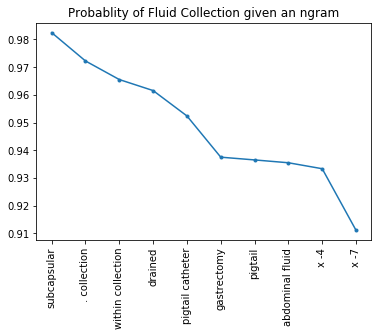

In [267]:
# Now plot this
n = 10
x = range(n)
words = [tup[0] for tup in cond_probs_to_plot[:n]]
# Plot the probablities
y = [tup[1]["cond_prob"] for tup in cond_probs_to_plot[:n]]
plt.plot(x, y, marker='.')
# Now add the text labels
# for i, (word, (prob, _)) in enumerate(cond_probs_to_plot[:n]):
#     plt.text(i, prob, word, rotation=-45)
plt.xticks(x, words, rotation=90)
_ = plt.title("Probablity of Fluid Collection given an ngram")

 ### 2b. Chi-Squared
 
 - Now do the same thing using a Chi-Squared Test with sklearn. I preprocessed the data and transformed it into matrices. See `Report Classification.ipynb` to see how I did this part.

In [269]:
DATADIR = '../stats_data'
INPATH = os.path.join(DATADIR, 'train_data.pkl')
VECTORIZER = os.path.join(DATADIR, 'vectorizer.pkl')

In [270]:
def load_data():
    with open(INPATH, 'rb') as f:
        X, y = pickle.load(f)
    with open(VECTORIZER, 'rb') as f:
        vectorizer = pickle.load(f)
    return X, y, vectorizer
X, y, vectorizer = load_data()

In [271]:
ch2 = SelectKBest(chi2, 100)
ch2.fit(X, y)

SelectKBest(k=100, score_func=<function chi2 at 0x109b4b048>)

In [272]:
def get_feature_scores(vectorizer, ch2):
    feature_names = vectorizer.get_feature_names()
    
    # (index, score)
    top_ranked = [(index, score) for (index, score)
                    in enumerate(ch2.scores_)]

    # Sort by score
    term_scores = [{'term': feature_names[idx], 'score': score} for (idx, score) in top_ranked]
    df = pd.DataFrame.from_dict(term_scores)
    df = df[['term', 'score']]
    return df
term_scores = get_feature_scores(vectorizer, ch2)
term_scores = term_scores.sort_values(by='score', ascending=False)
term_scores.head(n=10)

,term,score
117,collection,577.842366
259,fluid,284.480468
260,fluid collection,262.714097
288,hematoma,210.474145
115,cm,194.536101
213,drain,133.412460
214,drainage,106.216275
118,collections,101.425366
261,fluid collections,72.274042
99,catheter,67.579676


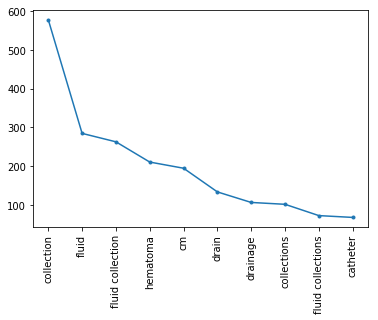

In [273]:
# Now plot the top 10 terms against their Chi2 scores
x = range(10)
terms = term_scores["term"].iloc[:10]
y = term_scores["score"].iloc[:10]

plt.plot(x, y, marker='.')
_ = plt.xticks(x, terms,rotation=90)

Using both methods of salience ranking, we can see that we can find terms that are reasonably associated with fluid collections. This indicates that probabilistic/statistical methods may be ef